In [ ]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
# selected_features = [
#     '한국 외환 보유액', '한국 상품수지', '외국인 투자 금액', '경제 심리 지수',
#     'WTI 유가', '두바이 유가', 'Brent 유가', '천연가스 가격', '유연탄 가격',
#     '구리 가격', '알루미늄 가격', '니켈 가격', '아연 가격', '대두 가격',
#     '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
#     '미국 주가지수', '한국 주가지수',
#     '미국 기준 금리', '한국 기준 금리',
#     '한국 10년 채권수익률', '실질GDP성장률'
# ]

# 유의미한 변수

In [ ]:
# 유의미한 변수
selected_features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
                        'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
                        '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률','M2',
                        '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
                        '외국인 투자 금액']

In [ ]:
import pandas as pd
exchange = pd.read_csv('/content/exchange_final.csv')
m2 = pd.read_csv('/content/M2_2000_2024.CSV' , encoding='cp949')

In [ ]:
# 날짜 포맷 맞추기
exchange['TIME'] = pd.to_datetime(exchange['TIME']).dt.strftime('%Y-%m')

# m2 인코딩해서 불러오기
m2 = pd.read_csv('/content/M2_2000_2024.CSV', encoding='cp949')  # 또는 euc-kr

# 조인 (왼쪽 기준: exchange 기준으로 붙이기)
df = pd.merge(exchange, m2, on='TIME', how='left')

In [ ]:
# 1. 데이터 로드 및 보간
df = df.interpolate(method='linear')
df = df.fillna(method='ffill').fillna(method='bfill')

<ipython-input-35-a8a633bef2ea>:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

<ipython-input-35-a8a633bef2ea>:3: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



# 변화량 중심으로 피처 생성

In [ ]:
# 1. 변화량(diff) 적용
X_diff = df[selected_features].diff().dropna()

# 2. 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_diff)

# 3. 클러스터링
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

# 4. 결과 추가 (dropna된 X_diff의 인덱스를 사용)
df_diff = df.loc[X_diff.index].copy()
df_diff['Cluster'] = clusters


In [ ]:
a = df_diff[['TIME','Cluster']]
a.to_csv('a.csv', index=False)

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

# 1. PCA로 2D 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. 시각화 데이터프레임 준비
df_plot = df_diff.copy()
df_plot['PCA1'] = X_pca[:, 0]
df_plot['PCA2'] = X_pca[:, 1]

# 3. Plotly로 그리기 (마우스 오버 가능!)
fig = px.scatter(
    df_plot,
    x='PCA1',
    y='PCA2',
    color='Cluster',
    hover_data={
        'TIME': True,
        '원/달러환율': True,
        'Cluster': True,
        'PCA1': False,
        'PCA2': False,
    },
    title='변화량 기반 KMeans 클러스터링 (PCA 2D)'
)

fig.update_layout(
    width=1000,
    height=600,
    legend_title='Cluster',
    template='plotly_white'
)

fig.show()

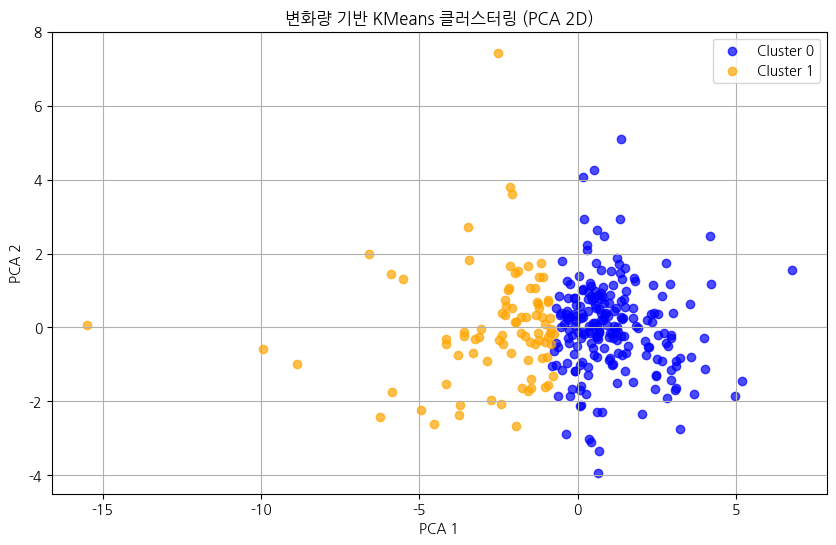

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# 시각화
plt.figure(figsize=(10, 6))

colors = {0: 'blue', 1: 'orange'}
for cluster_label in df_plot['Cluster'].unique():
    subset = df_plot[df_plot['Cluster'] == cluster_label]
    plt.scatter(subset['PCA1'], subset['PCA2'],
                label=f'Cluster {cluster_label}', alpha=0.7, c=colors[cluster_label])

plt.title('변화량 기반 KMeans 클러스터링 (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

- 0 : 위기상황 ( 넓게 퍼진 변화량 큰 집단 : 변동성이 큼)
- 1 : 평시

* 유의미한 피처들로 클러스터링 했을 떄


| 이벤트           | 기간                          | 총 관측치 수 | Cluster 0 수 | Cluster 0 비율 |
|------------------|-------------------------------|--------------|----------------|-----------------|
| 닷컴 버블        | 2000-03-01 ~ 2002-10-31       | 32           | 25             | 0.78            |
| 글로벌 금융위기  | 2008-09-01 ~ 2009-03-31       | 7            | 2              | 0.29            |
| 코로나 팬데믹    | 2020-03-01 ~ 2021-06-30       | 16           | 13             | 0.81            |
| 자이언트 스텝    | 2022-03-01 ~ 2023-07-31       | 17           | 7              | 0.41            |


| 이벤트          | Cluster 0 비율 | 해석                                   |
| ------------ | ------------ | ------------------------------------ |
| **닷컴 버블**    | **0.78**     | ✔️ 대부분의 시점에서 불안정한 변화 감지 (위기 잘 포착)    |
| **글로벌 금융위기** | **0.29**     | ⚠️ 일부만 감지됨 (짧은 기간, 위기 반영이 약함)        |
| **코로나 팬데믹**  | **0.81**     | ✔️ 매우 높은 비율, 패닉적 변화 잘 포착             |
| **자이언트 스텝**  | **0.41**     | ⚠️ 반반 정도 포착 (시장 충격이 점진적이었던 영향일 수 있음) |

      [결과]

      Cluster 0은 크고 급격한 변화량이 발생하는 불안정 구간을 잘 잡고 있음.
      특히 닷컴 버블, 코로나 팬데믹은 높은 비율로 잘 포착됨.
      금융위기, 자이언트스텝은 일부 구간만 잡힘 → 구조적으로 짧거나 변동성이 일정한 패턴일 수도 있음.
      → 이건 변화량 기준 클러스터링의 한계 또는 시장 반응의 완화로 해석 가능


► Cluster 0은 변화량이 큰 불안정 구간을 대표하며,
특히 닷컴 버블(78%)과 코로나 팬데믹(81%) 시기에는 높은 비율로 등장해 급변하는 경제 환경을 민감하게 포착했다.

반면, 금융위기(29%)와 자이언트 스텝(41%)에서는 일부만 감지되어, 점진적 변화나 정책 개입 영향으로 변화량이 상대적으로 덜 표현된 것으로 해석할 수 있다.

### 유의미한 소수 피처 기반 p-value 검정 코드 유의성검정

- t-test p-value < 0.05 또는 Mann-Whitney p-value < 0.05이면 유의미한 차이

- Cluster 0의 평균이 **더 나쁘다 (감소 or 증가)**면 → 해당 변수는 위기 구간에서 민감하게 반응한 지표

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# selected_features: 소수 변수 리스트
selected_features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
                     'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
                     '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률','M2',
                     '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
                     '외국인 투자 금액']

# df_diff: 변화량 + 클러스터 정보 포함된 데이터프레임
# 'Cluster' 컬럼: 0 or 1

def compare_clusters(df, selected_features):
    results = []

    for col in selected_features:
        # 1. 각 변수별로 클러스터 0과 1값 분리
        group_0 = df[df['Cluster'] == 0][col].dropna()
        group_1 = df[df['Cluster'] == 1][col].dropna()

        # 2. 두 그룹간의 평균 차이가 유의한지 확인 (t-test)
        t_stat, t_p = ttest_ind(group_0, group_1, equal_var=False)

        # 비모수 검정 (Mann-Whitney U test)
        u_stat, u_p = mannwhitneyu(group_0, group_1, alternative='two-sided')

        #  정규성 가정이 어려운 경우를 대비한 비모수 검정 # 결과는 평균값, t-test, 비모수 검정의 p-value까지 모두 수록
        results.append({
            '변수': col,
            'Cluster 0 평균': group_0.mean(),
            'Cluster 1 평균': group_1.mean(),
            't-test p-value': round(t_p, 4),
            'Mann-Whitney p-value': round(u_p, 4)
        })

    return pd.DataFrame(results)

# 실행
result_small_features = compare_clusters(df_diff, selected_features)

# 결과 테이블 보기
pd.set_option('display.max_rows', None)  # 필요시 전체 행 보기
pd.set_option('display.max_columns', None)
display(result_small_features)

# 또는 간단히
# print(result_small_features)

,변수,Cluster 0 평균,Cluster 1 평균,t-test p-value,Mann-Whitney p-value
0,경제 심리 지수,1.011526e+02,9.779884e+01,0.0110,0.0135
1,한국 외환 보유액,3.058692e+05,3.330613e+05,0.0134,0.0243
2,vix,1.881254e+01,2.265116e+01,0.0017,0.0038
3,WTI 유가,6.199714e+01,6.825942e+01,0.0566,0.0538
4,한국 실업률,3.538967e+00,3.394186e+00,0.0104,0.0076
5,두바이 유가,6.196446e+01,7.091430e+01,0.0136,0.0160
6,Brent 유가,6.458606e+01,7.323663e+01,0.0194,0.0219
7,천연가스 가격,4.454460e+00,4.128605e+00,0.2065,0.3164
8,유연탄 가격,8.787277e+01,1.174856e+02,0.0088,0.0020
9,미국 주가지수,9.198216e+01,9.867326e+01,0.1260,0.0784


# 가설을 세운 모든 변수

In [ ]:
# 변수 정의
features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            'M2', '실질GDP성장률', 'vix']

In [ ]:
# 1. 변화량(diff) 적용
X_diff = df[features].diff().dropna()

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_diff)

# 3. 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 4. 클러스터 결과 추가
df_diff = df.loc[X_diff.index].copy()
df_diff['Cluster'] = clusters

In [ ]:
df[features].isna().sum()

,0
경제 심리 지수,0
한국 기준 금리,0
미국 기준 금리,0
한국 외환 보유액,0
한국 실업률,0
미국 실업률,0
한국 주가지수,0
미국 주가지수,0
WTI 유가,0
두바이 유가,0


In [ ]:
df_diff

,Unnamed: 0,TIME,원/달러환율,한국 장기 시장 금리,미국 장기 시장 금리,중국 장기 시장 금리,한국 단기 시장 금리,미국 단기 시장 금리,중국 단기 시장 금리,전체 수출 총액,...,인플레이션 격차,실질GDP,실질GDP성장률,vix,M2,증가율,Cluster,환율변화량,abs_diff,연도
1,1,2000-02,1129.29,8.25,6.52,4.50,7.13,6.01,2.73,12676042,...,-0.289861,8.768602e+05,-8.290570,23.37,677.6103,0.4,1,-1.03,1.03,2000
2,2,2000-03,1115.75,8.25,6.26,4.50,7.00,6.14,2.64,14429703,...,-0.289861,8.705981e+05,-8.290570,24.11,685.3970,1.1,1,-13.54,13.54,2000
3,3,2000-04,1110.01,8.25,5.99,4.50,7.06,6.28,2.64,13522040,...,-0.289861,8.643727e+05,-8.290570,26.20,689.5531,0.6,0,-5.74,5.74,2000
4,4,2000-05,1121.37,8.25,6.44,4.50,7.14,6.71,2.57,14636755,...,-0.289861,8.581835e+05,-8.290570,23.65,688.6894,-0.1,1,11.36,11.36,2000
5,5,2000-06,1117.67,8.25,6.10,4.50,7.17,6.73,2.45,15250940,...,-0.289861,8.520304e+05,-8.290570,19.54,689.5090,0.1,1,-3.70,3.70,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,2024-08,1352.87,3.00,3.87,2.17,3.50,5.12,2.04,57644555,...,-0.519972,1.651142e+06,-1.623182,15.00,4067.9142,0.3,0,-30.50,30.50,2024
296,296,2024-09,1332.76,3.01,3.72,2.15,3.52,4.86,2.06,58551357,...,-0.844514,1.651142e+06,-1.298546,16.73,4078.0968,0.3,1,-20.11,20.11,2024
297,297,2024-10,1365.37,3.07,4.10,2.15,3.43,4.62,2.10,57508046,...,-1.335708,1.651142e+06,-0.973909,23.16,4116.3931,0.9,1,32.61,32.61,2024
298,298,2024-11,1394.32,3.01,4.36,2.02,3.42,4.53,2.04,56302773,...,-1.223013,1.651142e+06,-0.649273,13.51,4148.2109,0.8,0,28.95,28.95,2024


In [ ]:
b = df_diff[['TIME','Cluster']]
b.to_csv('b.csv', index=False)

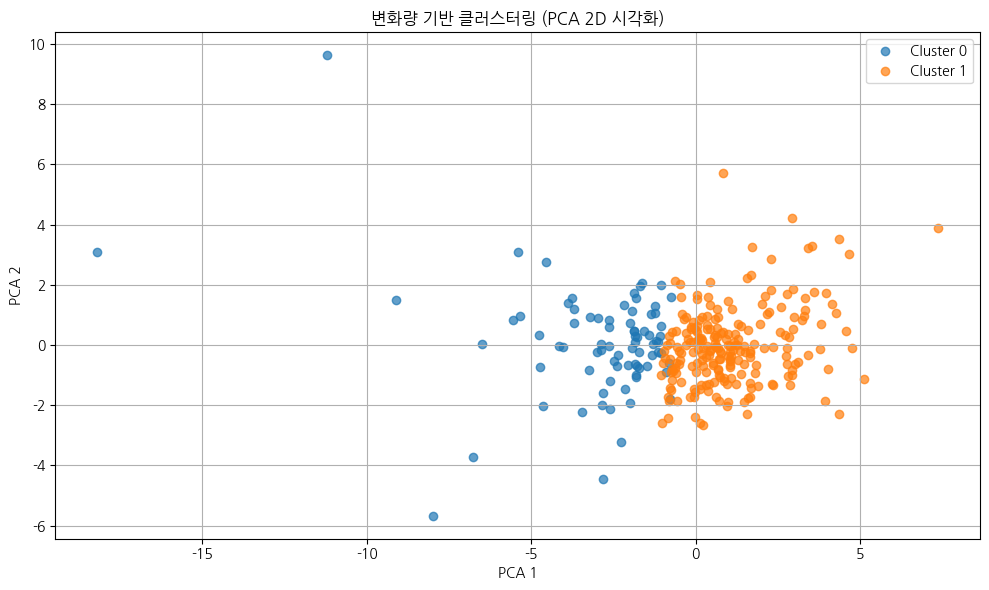

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 5. PCA로 2D 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 6. 결과 DataFrame에 PCA 결과 추가
df_diff['PCA1'] = X_pca[:, 0]
df_diff['PCA2'] = X_pca[:, 1]

# 7. 시각화
plt.figure(figsize=(10, 6))
colors = {0: 'tab:blue', 1: 'tab:orange'}

for cluster_label in sorted(df_diff['Cluster'].unique()):
    subset = df_diff[df_diff['Cluster'] == cluster_label]
    plt.scatter(subset['PCA1'], subset['PCA2'],
                label=f'Cluster {cluster_label}',
                alpha=0.7,
                color=colors[cluster_label])

plt.title('변화량 기반 클러스터링 (PCA 2D 시각화)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


| 이벤트           | 기간                          | 총 관측치 수 | Cluster 0 수 | Cluster 0 비율 |
|------------------|-------------------------------|--------------|----------------|-----------------|
| 닷컴 버블        | 2000-03-01 ~ 2002-10-31       | 32           | 6              | 0.19            |
| 글로벌 금융위기  | 2008-09-01 ~ 2009-03-31       | 7            | 5              | 0.71            |
| 코로나 팬데믹    | 2020-03-01 ~ 2021-06-30       | 16           | 2              | 0.12            |
| 자이언트 스텝    | 2022-03-01 ~ 2023-07-31       | 17           | 9              | 0.53            |




# 두 클러스터링 결과 비교

| 이벤트      | 기존 클러스터링 (소수 변수) | 확장 변수 클러스터링 |
| -------- | ---------------- | ----------- |
| 닷컴 버블    | **0.78**         | **0.19**    |
| 글로벌 금융위기 | 0.29             | **0.71**    |
| 코로나 팬데믹  | **0.81**         | 0.12        |
| 자이언트 스텝  | 0.41             | **0.53**    |


소수 변수 기반 클러스터링은 감도 높고 날카롭게 일부 위기를 포착함 (ex. 코로나, 닷컴)

확장 변수 기반 클러스터링은 금융 시스템 전반의 충격이 반영된 위기 (글로벌 금융위기, 자이언트스텝)에 더 강함

즉,
감도 높은 조기 탐지는 소수 변수
전방위 충격 감지는 확장 변수
→ 둘을 보완적으로 활용할 수 있음

| 구분                 | 소수 변수 기반 클러스터링                     | 확장 변수 기반 클러스터링                    |
|----------------------|-----------------------------------------------|----------------------------------------------|
| 변수 구성           | 경제심리지수, 외환보유액, VIX 등 주요 변수 추림 | 경제 전반을 포괄하는 30여 개 변수 전체 사용 |
| 감지 특성           | 민감도 높음, 급격한 변동에 빠르게 반응        | 종합성 높음, 구조적 변화 반영에 유리        |
| 강점 위기 유형       | 시장 불안, 단기 충격 중심 (ex. 코로나)         | 시스템 리스크, 구조적 위기 (ex. 금융위기)   |
| 해석 방향           | 조기 신호 탐지용                                | 위기 구조 분석용                              |
| 해석 신뢰도 관점     | 심리 기반 단정은 어려움 → 상대적 강조로 해석    | 구조 기반 단정은 어려움 → 종합성 중심 해석   |


> 두 클러스터링은 유사한 변수군을 기반으로 하지만, 구성의 폭과 강조점에서 차이를 보입니다.  
> 소수 변수 기반 클러스터는 상대적으로 민감하게 반응하여 급격한 변화의 조기 신호로 활용할 수 있으며,  
> 확장 변수 기반 클러스터는 경제 전반의 구조적 변화를 반영해 시스템 차원의 위험 감지에 유리한 경향을 보였습니다.  
> 따라서 단일 해석보다는, 각각의 감지 특성을 상호보완적으로 활용하는 접근이 적절합니다.

    두 클러스터링은 유사한 지표군을 기반으로 하지만,
    변수 구성의 폭과 강조점에서 차이를 보입니다.

    소수 변수 기반은 민감도(변화 감지 능력) 측면에서,
    확장 변수 기반은 종합성(다층적 변화 반영) 측면에서 강점을 보입니다.

# 두개의 클러스터링 결과를 모두 활용

| 이벤트           | 소수 클러스터 0 비율 | 확장 클러스터 0 비율 | 해석 방향       | 위기 유형 분류    |
|------------------|----------------------|-----------------------|------------------|-------------------|
| 닷컴 버블        | 0.78                 | 0.19                  | 심리적 반응 강함 | 📢 심리 기반 위기 |
| 글로벌 금융위기  | 0.29                 | 0.71                  | 구조 변화 강함   | 🏦 구조 기반 위기 |
| 코로나 팬데믹    | 0.81                 | 0.12                  | 급변한 심리 반응 | 📢 심리 기반 위기 |
| 자이언트 스텝    | 0.41                 | 0.53                  | 양쪽 모두 반응   | ⚠️ 복합 위기       |



| 위기 유형       | 경보 아이콘        | 메시지 예시                                                  |
| ----------- | ------------- | ------------------------------------------------------- |
| 📢 심리 기반 위기 | “시장 심리 불안 경보” | 금융시장 심리가 급변하고 있으며, 정책적 신뢰 회복이 중요합니다.                    |
| 🏦 구조 기반 위기 | “시스템 리스크 경보”  | 주요 거시지표의 구조적 변화가 감지되었습니다. 통화·재정정책의 공조 대응이 요구됩니다.        |
| ⚠️ 복합 위기    | “복합 위기 경보”    | 시장 심리와 경제 시스템 모두에서 이상 징후가 나타나고 있습니다. 전방위적 위기 대응이 필요합니다. |

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# selected_features: 소수 변수 리스트
selected_features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
                     'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
                     '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률','M2',
                     '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
                     '외국인 투자 금액']

# df_diff: 변화량 + 클러스터 정보 포함된 데이터프레임
# 'Cluster' 컬럼: 0 or 1

def compare_clusters(df, selected_features):
    results = []

    for col in selected_features:
        # 1. 각 변수별로 클러스터 0과 1값 분리
        group_0 = df[df['Cluster'] == 0][col].dropna()
        group_1 = df[df['Cluster'] == 1][col].dropna()

        # 2. 두 그룹간의 평균 차이가 유의한지 확인 (t-test)
        t_stat, t_p = ttest_ind(group_0, group_1, equal_var=False)

        # 비모수 검정 (Mann-Whitney U test)
        u_stat, u_p = mannwhitneyu(group_0, group_1, alternative='two-sided')

        #  정규성 가정이 어려운 경우를 대비한 비모수 검정 # 결과는 평균값, t-test, 비모수 검정의 p-value까지 모두 수록
        results.append({
            '변수': col,
            'Cluster 0 평균': group_0.mean(),
            'Cluster 1 평균': group_1.mean(),
            't-test p-value': round(t_p, 4),
            'Mann-Whitney p-value': round(u_p, 4)
        })

    return pd.DataFrame(results)

# 실행
result_small_features = compare_clusters(df_diff, selected_features)

# 결과 테이블 보기
pd.set_option('display.max_rows', None)  # 필요시 전체 행 보기
pd.set_option('display.max_columns', None)
display(result_small_features)

# 또는 간단히
# print(result_small_features)

,변수,Cluster 0 평균,Cluster 1 평균,t-test p-value,Mann-Whitney p-value
0,경제 심리 지수,9.796329e+01,1.009868e+02,0.0286,0.0308
1,한국 외환 보유액,3.304112e+05,3.076860e+05,0.0438,0.0675
2,vix,2.320494e+01,1.873582e+01,0.0006,0.0006
3,WTI 유가,6.938076e+01,6.179373e+01,0.0249,0.0221
4,한국 실업률,3.374684e+00,3.541364e+00,0.0031,0.0034
5,두바이 유가,7.195038e+01,6.187718e+01,0.0069,0.0072
6,Brent 유가,7.437810e+01,6.445141e+01,0.0091,0.0095
7,천연가스 가격,4.240506e+00,4.403909e+00,0.5419,0.6821
8,유연탄 가격,1.206091e+02,8.769336e+01,0.0061,0.0011
9,미국 주가지수,9.795190e+01,9.245409e+01,0.2242,0.1784


# 결과적으로

- 위기 탐지 관점에서 비교

| 기준                   | 소수 피처셋                   | 전체 피처셋             |
| -------------------- | ------------------------ | ------------------ |
| **패닉기 (VIX↑, GDP↓)** | **불명확** (VIX 낮거나 GDP 높음) | ✅ 명확히 포착           |
| **정책 대응 (M2↑, 금↑)**  | 부분 포착                    | ✅ 전체적으로 강하게 반영     |
| **시장 충격/자산 가격 반영**   | 유가, 외환 등 구조 반응만          | ✅ 금, 유연탄, 구리 등도 포함 |
| **심리지표 일관성**         | 높기도 하고 낮기도 함 (해석 혼란)     | ✅ 위기 구간에서 심리 하락 일관 |


<전체 피처셋>

**위기일수록 → GDP 성장률 ↓, 심리지수 ↓, 금 가격 ↑, M2 ↑, 실업률 ↑**

이건 거시경제 정책 반응이 따라붙는 **위기의 전형적 모습**

정책 결정자 입장에서 위기를 진단하는 데 필요한 지표들이 고루 반영됨

> 경제학적 정합성과 변수 간 해석 일관성을 기준으로 볼 때, 전체 피처셋 기반 클러스터링은 실질 GDP  성장률 하락, 금 가격 상승, 유동성 공급 확대 등 전형적인 위기 특성을 명확히 반영하고 있으며, 위기 탐지 성능 면에서 더 우수하다. 반면 소수 피처셋은 변화량에 민감한 구조를 통해 조기 경보 기능은 제공하나, 거시경제적 위기의 구조적 특성을 포착하는 데에는 한계가 있다.